In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Face Recognition/celebA_train_500.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: celebA_train_500/celebA_imgs/065463.jpg  
  inflating: celebA_train_500/celebA_imgs/138002.jpg  
  inflating: celebA_train_500/celebA_imgs/019966.jpg  
  inflating: celebA_train_500/celebA_imgs/037443.jpg  
  inflating: celebA_train_500/celebA_imgs/132249.jpg  
  inflating: celebA_train_500/celebA_imgs/067274.jpg  
  inflating: celebA_train_500/celebA_imgs/078354.jpg  
  inflating: celebA_train_500/celebA_imgs/038764.jpg  
  inflating: celebA_train_500/celebA_imgs/017787.jpg  
  inflating: celebA_train_500/celebA_imgs/036749.jpg  
  inflating: celebA_train_500/celebA_imgs/067260.jpg  
  inflating: celebA_train_500/celebA_imgs/125721.jpg  
  inflating: celebA_train_500/celebA_imgs/077073.jpg  
  inflating: celebA_train_500/celebA_imgs/139308.jpg  
  inflating: celebA_train_500/celebA_imgs/120881.jpg  
  inflating: celebA_train_500/celebA_imgs/161163.jpg  
  inflating: celebA_train_500/celebA_imgs/127136.jpg

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34, resnet18, resnet50, efficientnet_v2_m, efficientnet_b0
import os
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import torch.nn.functional as F
import pandas as pd
import gc
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.nn.utils.parametrizations import weight_norm
import math
import torchvision.transforms as T
import warnings
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings("ignore")

#Models & Losses

In [2]:
class Recognizer(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.encoder = params["encoder"]
    encoder_emb_size = params["encoder_emb_size"]
    encoder_last_layer_name = params["encoder_last_layer_name"]
    new_last_layer = nn.Sequential(
        nn.BatchNorm1d(encoder_emb_size),
        nn.Dropout(0.2),
        nn.Linear(encoder_emb_size, 256),
    )
    setattr(self.encoder, encoder_last_layer_name, new_last_layer)
    self.n_classes = params.get("n_classes", 500)
    self.classifier = nn.Linear(256, self.n_classes, bias=False)
    self.loss = nn.CrossEntropyLoss()

  def forward(self, batch):
    images = batch["images"]
    labels = batch["labels"]

    preds = self.classifier(self.encoder(images))
    loss = self.loss(preds, labels)
    return loss
  def predict(self, x):
    x = x["images"]
    x = self.encoder(x)
    x = self.classifier(x)
    output = {
        "preds":x
    }
    return output

In [3]:
class Recognizer_ArcFaceLoss(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.encoder = params["encoder"]
    encoder_emb_size = params["encoder_emb_size"]
    encoder_last_layer_name = params["encoder_last_layer_name"]
    new_last_layer = nn.Sequential(
        nn.BatchNorm1d(encoder_emb_size),
        nn.Dropout(0.2),
        nn.Linear(encoder_emb_size, 256),
    )
    setattr(self.encoder, encoder_last_layer_name, new_last_layer)
    self.n_classes = params.get("n_classes", 500)
    self.classifier = nn.Linear(256, self.n_classes, bias=False)
    self.s = params.get("s", 10)
    self.m = params.get("m", 0.1)

  def forward(self, batch):
    images = batch["images"]
    labels = batch["labels"]

    embeddings = self.encoder(images)
    embeddings = F.normalize(embeddings, dim=1)
    weight_norm = F.normalize(self.classifier.weight.T, dim=0)

    cos_theat = torch.matmul(embeddings, weight_norm)
    sin_theat = torch.sqrt(1.0-torch.pow(cos_theat,2))
    cos_theat_m = cos_theat*math.cos(self.m)-sin_theat*math.sin(self.m)
    cos_theat_ = torch.exp(cos_theat * self.s)
    sum_cos_theat = torch.sum(torch.exp(cos_theat*self.s),dim=1,keepdim=True)-cos_theat_
    top = torch.exp(cos_theat_m*self.s)
    divide = (top/(top+sum_cos_theat))

    nll = nn.NLLLoss()
    log = torch.log(divide)
    loss = nll(log, labels.argmax(dim=1))
    return loss

  def predict(self, x):
    x = x["images"]
    x = self.encoder(x)
    x = self.classifier(x)
    output = {
        "preds":x
    }
    return output

In [4]:
class Recognizer_TripletLoss(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.encoder = params["encoder"]
    encoder_emb_size = params["encoder_emb_size"]
    encoder_last_layer_name = params["encoder_last_layer_name"]
    new_last_layer = nn.Sequential(
        nn.BatchNorm1d(encoder_emb_size),
        nn.Dropout(0.2),
        nn.Linear(encoder_emb_size, 256),
    )
    setattr(self.encoder, encoder_last_layer_name, new_last_layer)
    self.n_classes = params.get("n_classes", 500)
    self.loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

    self.predict_dataset = params["predict_dataset"]
    self.k = params.get("k", 3)
    self.knn = KNeighborsClassifier(self.k)

  def forward(self, batch):
    anchors = batch["anchors"]
    positives = batch["positives"]
    negatives = batch["negatives"]

    a_embs = self.encoder(anchors)
    p_embs = self.encoder(positives)
    n_embs = self.encoder(negatives)
    loss = self.loss(a_embs, p_embs, n_embs)
    return loss
  def predict(self, x):
    x = x["images"]
    x = self.encoder(x)
    x = x.detach().cpu().numpy()
    pred = self.knn.predict(x)
    pred = torch.from_numpy(pred)
    output = {
        "preds":pred
    }
    return output
  def eval(self):
    self.train = False
    dataloader = DataLoader(self.predict_dataset, batch_size=16, shuffle=False)
    embeddings = None
    labels = None
    with torch.no_grad():
      for batch in tqdm(dataloader, desc="Preparing predicate"):
        images = batch["images"].to(self.device)
        embs = self.encoder(images)
        if embeddings == None:
          embeddings = embs.detach().cpu().numpy()
          labels = batch["labels"].detach().cpu().numpy()
        else:
          embeddings = np.concatenate([embeddings, embs.detach().cpu().numpy()])
          labels = np.concatenate([labels, batch["labels"].argmax(dim=1).detach().cpu().numpy()])
    self.knn.fit(embeddings, labels)


In [5]:
class Recognizer_ArcFaceLoss_TripletLoss(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.encoder = params["encoder"]
    encoder_emb_size = params["encoder_emb_size"]
    encoder_last_layer_name = params["encoder_last_layer_name"]
    new_last_layer = nn.Sequential(
        nn.BatchNorm1d(encoder_emb_size),
        nn.Dropout(0.2),
        nn.Linear(encoder_emb_size, 256),
    )
    setattr(self.encoder, encoder_last_layer_name, new_last_layer)
    self.n_classes = params.get("n_classes", 500)
    self.classifier = nn.Linear(256, self.n_classes, bias=False)
    self.s = params.get("s", 10)
    self.m = params.get("m", 0.1)
    self.triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

  def forward(self, batch):
    anchors = batch["anchors"]
    positives = batch["positives"]
    negatives = batch["negatives"]

    a_embs = self.encoder(anchors)
    p_embs = self.encoder(positives)
    n_embs = self.encoder(negatives)
    triplet_loss = self.triplet_loss(a_embs, p_embs, n_embs)

    labels = batch["labels"]
    embeddings = a_embs
    embeddings = F.normalize(embeddings, dim=1)
    weight_norm = F.normalize(self.classifier.weight.T, dim=0)

    cos_theat = torch.matmul(embeddings, weight_norm)
    sin_theat = torch.sqrt(1.0-torch.pow(cos_theat,2))
    cos_theat_m = cos_theat*math.cos(self.m)-sin_theat*math.sin(self.m)
    cos_theat_ = torch.exp(cos_theat * self.s)
    sum_cos_theat = torch.sum(torch.exp(cos_theat*self.s),dim=1,keepdim=True)-cos_theat_
    top = torch.exp(cos_theat_m*self.s)
    divide = (top/(top+sum_cos_theat))

    nll = nn.NLLLoss()
    log = torch.log(divide)
    arc_face_loss = nll(log, labels.argmax(dim=1))

    loss = triplet_loss + arc_face_loss
    return loss

  def predict(self, x):
    x = x["images"]
    x = self.encoder(x)
    x = self.classifier(x)
    output = {
        "preds":x
    }
    return output

#Datasets

In [6]:
class FaceDataset(Dataset):
  def __init__(self, params, train=True):
    self.path = params["path"]
    self.images_path = os.path.join(self.path, "celebA_imgs")
    self.labels = self.get_labels_dict(os.path.join(self.path, "celebA_anno.txt"))
    self.images = []
    for image in self.labels.keys():
      self.images.append(image)

    train_set, val_set = train_test_split(self.images, test_size=0.2, random_state=42)
    if train:
      self.images = train_set
    else:
      self.images = val_set

    self.n_labels = 500
    augmentations = params["augmentations"]
    compose = params.get("compose_augmentations", False)
    self.augmentations = []
    if augmentations != None:
      self.augmentations = self.prepare_augmentations(augmentations, compose)

  def __len__(self):
    return len(self.images)*(len(self.augmentations) + 1)
  def __getitem__(self, ind):
    num = ind + 1
    image_ind = int(ind/(len(self.augmentations) + 1))
    aug_ind = (ind+1) % (len(self.augmentations) + 1)
    if len(self.augmentations) == 0:
      image_ind = ind
      aug_ind = 0

    name = self.images[image_ind]
    label = int(self.labels[name])
    image = self.open_and_crop_image(name)

    if aug_ind != 0:
      image = self.augmentations[aug_ind - 1](image)

    transforms = T.Compose([T.Resize([120,120])])
    image_tensor = transforms(torch.Tensor(np.array(image)).permute(2, 0, 1))

    label_tensor = torch.LongTensor([label])
    ohe = F.one_hot(label_tensor, num_classes=self.n_labels).squeeze(0).type("torch.FloatTensor")
    output = {
        "train":{
            "images":image_tensor,
            "labels":ohe
        },
        "val":{
            "images":image_tensor,
        },
        "labels":{
            "labels":ohe
        },
    }
    return output
  def open_and_crop_image(self, name):
    image = np.array(Image.open(os.path.join(self.images_path, name)))
    image = Image.fromarray(image[77:-41, 45:-50])
    return image
  def get_labels_dict(self, labels_file):
    pairs = []
    with open(labels_file, "r") as f:
      pairs = f.read().split("\n")
    labels_dict = {}
    for pair in pairs:
      if pair == "":
        continue
      img, label = pair.split()
      labels_dict[img] = label
    return labels_dict
  def get_unique_labels(self, labels_dict):
    unique = []
    for label in labels_dict.values():
      int_label = int(label)
      if int_label not in unique:
        unique.append(int_label)
    return unique
  def prepare_augmentations(self, base_aug, compose):
    augmentations = []
    for aug in base_aug:
      augmentations.append(aug)
    if len(base_aug) == 1 or compose == False:
      return augmentations
    for i in range(len(base_aug)):
      for j in range(i, len(base_aug)):
        aug = T.Compose([base_aug[i], base_aug[j]])
        augmentations.append(aug)
    return augmentations
  def show_samples(self, n_samples):
    samples = random.sample(self.images, n_samples)
    fig, ax = plt.subplots(n_samples)
    for ind, img in enumerate(samples):
      image = self.open_and_crop_image(img)
      ax[ind].imshow(image)
    plt.show()
  def show_augmentations(self):
    img = random.sample(self.images, 1)[0]
    image = self.open_and_crop_image(img)
    augs = [image]
    for aug in self.augmentations:
      new_img = aug(image)
      augs.append(new_img)

    fig, ax = plt.subplots(len(augs), figsize=(5, 5*len(augs)))
    for ind, aug in enumerate(augs):
      ax[ind].imshow(aug)
    plt.show()

In [7]:
class FaceDataset_TripletLoss(FaceDataset):
  def __init__(self, params, train=True):
    super().__init__(params, train)
    self.labels_image_dict = self.reverse_labels_dict(self.labels)
    self.n_pos = params.get("n_pos", 1)
    self.n_neg = params.get("n_neg", 1)

    assert self.n_pos == self.n_neg, "Pos and neg counts should be equal"

    self.compose_triplets = params.get("compose_triplets", False)
    self.triplets = self.get_triplets()
    self.n_triplets = self.n_pos if self.compose_triplets == False else self.n_pos*self.n_neg

  def __len__(self):
    return len(self.images)*(len(self.augmentations) + 1)*self.n_triplets
  def __getitem__(self, ind):
    num = ind + 1
    image_ind = int(ind/(len(self.augmentations) + 1)/self.n_triplets)
    triplet_ind = int((ind - (image_ind)*(len(self.augmentations) + 1)*self.n_triplets)/(len(self.augmentations) + 1))
    aug_ind = ind - (image_ind)*(len(self.augmentations) + 1)*self.n_triplets - triplet_ind*(len(self.augmentations) + 1)

    name = self.images[image_ind]
    triplet = self.triplets[name]

    anchor = self.open_and_crop_image(name)
    pos = self.open_and_crop_image(triplet[pos])
    neg = self.open_and_crop_image(triplet[neg])
    triplet = [anchor, pos, neg]

    if aug_ind != 0:
      for i in range(len(triplet)):
        triplet[i] = self.augmentations[aug_ind - 1](triplet[i])

    transforms = T.Compose([T.Resize([120,120])])
    for i in range(len(triplet)):
      triplet[i] = transforms(torch.Tensor(np.array(triplet[i])).permute(2, 0, 1))

    label = int(self.labels[name])
    label_tensor = torch.LongTensor([label])
    label_ohe = F.one_hot(label_tensor, num_classes=self.n_labels).squeeze(0).type("torch.FloatTensor")

    output = {
        "train":{
            "anchors":triplet[0],
            "positives":triplet[1],
            "negatives":triplet[2]
        },
        "val":{
            "images":triplet[0],
        },
        "labels":{
            "labels":label_ohe
        }
    }
    return output
  def reverse_labels_dict(self, labels_dict):
    reversed = {}
    for image in labels_dict.keys():
      label = labels_dict[image]
      if label not in reversed:
        reversed[label] = [image]
      else:
        reversed[label].append(image)
    return reversed
  def get_triplets(self):
    triplets = []
    for image in self.images:
      label = self.labels[image]

      pos = random.sample(self.labels_image_dict[label], self.n_pos)
      if self.n_pos + 1 > len(self.labels_image_dict[label]):
        while image in pos:
          pos = random.sample(self.labels_image_dict[label], self.n_pos)

      neg = []
      while len(neg) < self.n_neg:
        img = random.sample(self.images, 1)[0]
        if self.labels[img] != label and img not in neg:
          neg.append(img)

      assert len(pos) == len(neg), "Can't get triplets"

      image_triplets = []
      if self.compose_triplets == False:
        for i in range(len(pos)):
          trip = {"pos":pos[i], "neg":neg[i]}
          image_triplets.append(trip)
      else:
        for i in range(len(pos)):
          for j in range(len(neg)):
            trip = {"pos":pos[i], "neg":neg[j]}
            image_triplets.append(trip)
      triplets.append({image:image_triplets})
    return triplets

#Training classes

In [8]:
class Trainer():
  def __init__(self, params):
    self.train_dataloader = params["train_dataloader"]
    self.val_dataloader = params["val_dataloader"]
    self.score = params["score"]
    self.optimizer = params["optimizer"]
    self.optimizer_args = params["optimizer_args"]
    self.scheduler = params["scheduler"]
    self.scheduler_args = params["scheduler_args"]
    self.freezer = params["freezer"]
    self.freezer_args = params["freezer_args"]
    self.n_epochs = params["n_epochs"]
    self.device = params["device"]
    self.backup_path = params.get("backup_path", None)
    self.history = {
        "train_loss":[],
        "train_score":[],
        "val_loss":[],
        "val_score":[]
    }
  def train(self, model, verbose=True):
    model = model.to(self.device)
    optimizer = self.optimizer(model.parameters(), **self.optimizer_args)
    scheduler = None
    if self.scheduler != None and self.scheduler_args != None:
      scheduler = self.scheduler(optimizer, **self.scheduler_args)
    freezer = None
    if self.freezer != None and self.freezer_args != None:
      freezer = self.freezer(model, **self.freezer_args)

    for epoch in range(self.n_epochs):
      #Training
      model.train()
      if freezer != None:
        freezer.step()
      train_loss = 0
      train_score = 0
      for batch in tqdm(self.train_dataloader, desc="Training"):
        train_batch = batch["train"]
        for key in train_batch.keys():
          train_batch[key] = train_batch[key].to(self.device)

        loss = model(train_batch)
        loss.backward()
        train_loss += loss.item()/len(self.train_dataloader)
        optimizer.step()
        optimizer.zero_grad()

        val_batch = batch["val"]
        for key in val_batch.keys():
          val_batch[key] = val_batch[key].to(self.device)
        labels = batch["labels"]
        for key in labels.keys():
          labels[key] = labels[key].to(self.device)

        preds = model.predict(val_batch)
        score = self.score(preds, labels)
        train_score += score/(len(self.train_dataloader))

      if scheduler != None:
        scheduler.step()

      #Validation
      model.eval()
      val_loss = 0
      val_score = 0
      for batch in tqdm(self.val_dataloader, desc="Validation"):
        train_batch = batch["train"]
        for key in train_batch.keys():
          train_batch[key] = train_batch[key].to(self.device)

        optimizer.zero_grad()
        loss = model(train_batch)
        val_loss += loss.item()/len(self.val_dataloader)

        val_batch = batch["val"]
        for key in val_batch.keys():
          val_batch[key] = val_batch[key].to(self.device)
        labels = batch["labels"]
        for key in labels.keys():
          labels[key] = labels[key].to(self.device)

        preds = model.predict(val_batch)
        score = self.score(preds, labels)
        val_score += score/(len(self.val_dataloader))

      self.history["train_loss"].append(train_loss)
      self.history["train_score"].append(train_score)
      self.history["val_loss"].append(val_loss)
      self.history["val_score"].append(val_score)
      if verbose:
        print(f"Epoch {epoch+1}. Train loss: {train_loss}, val loss: {val_loss}, train score: {train_score}, val score: {val_score}")

      if self.backup_path != None:
        torch.save(model, self.backup_path)
    self.save_history()

  def save_history(self):
    fig, ax = plt.subplots()
    ax.plot(range(len(self.history["train_loss"])), self.history["train_loss"], label="Train")
    ax.plot(range(len(self.history["val_loss"])), self.history["val_loss"], label="Val")
    fig.savefig("Losses.pdf")

    fig, ax = plt.subplots()
    ax.plot(range(len(self.history["train_score"])), self.history["train_score"], label="Train")
    ax.plot(range(len(self.history["val_score"])), self.history["val_score"], label="Val")
    fig.savefig("Scores.pdf")

  def plot_lr_schedule(self):
    steps = [self.optimizer_args["lr"]]
    if self.scheduler == None or self.scheduler_args == None:
      steps = [self.optimizer_args["lr"] for i in range(self.n_epochs)]
    else:
      dummyModel = nn.Linear(10, 10)
      dummyOptimizer = self.optimizer(dummyModel.parameters(), **self.optimizer_args)
      scheduler = scheduler = self.scheduler(dummyOptimizer, **self.scheduler_args)
      for i in range(1, self.n_epochs):
        dummyOptimizer.step()
        scheduler.step()
        lr = scheduler.get_last_lr()[0]
        steps.append(lr)
    fig, ax = plt.subplots()
    ax.plot(range(len(steps)), steps)
    plt.show()


In [9]:
class AccuracyScore():
  def __call__(self, preds, labels):
    y_true = labels["labels"].detach().cpu().numpy()
    y_pred = preds["preds"].detach().cpu().numpy()
    if len(y_true.shape) > 1:
      y_true = np.argmax(y_true, axis=1)
    if len(y_pred.shape) > 1:
      y_pred = np.argmax(y_pred, axis=1)
    score = accuracy_score(y_true, y_pred)
    return score

In [10]:
class LayerFreezer():
  def __init__(self, model, strategy, parent=None):
    self.model = model
    self.strategy = strategy
    self.epoch_counter = 0
    self.parent = parent
  def step(self):
    cur_model = self.model
    if self.parent != None:
      for child in self.model.named_children():
        if child[0] == self.parent:
          cur_model = child[1]
          break
    for param in cur_model.parameters():
        param.requires_grad = True
    if self.epoch_counter == len(self.strategy):
      return
    cur_layers = self.strategy[self.epoch_counter]
    layer_counter = 0
    for layer in cur_model.children():
      if layer_counter < cur_layers:
        for param in layer.parameters():
          param.requires_grad = False
        layer_counter += 1
    self.epoch_counter += 1


#Hyperparameters and training

In [17]:
batch_size = 16
path = "/content/celebA_train_500"
train_data_params = {
    "path":path,
    "augmentations":None,
    "compose_augmentations":False
}
train_dataset = FaceDataset(train_data_params, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_data_params = {
    "path":path,
    "augmentations":None
}
val_dataset = FaceDataset(val_data_params, train=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

trainer_args = {
    "train_dataloader":train_dataloader,
    "val_dataloader":val_dataloader,
    "score":AccuracyScore(),
    "optimizer":torch.optim.AdamW,
    "optimizer_args":{"lr":3e-4, "weight_decay":0.01},
    "scheduler":None,
    "scheduler_args":None,
    "freezer":None,
    "freezer_args":None,
    "n_epochs":50,
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "backup_path":"/content/drive/MyDrive/Face Recognition/recognizer_v6.pt"
}
[9, 9, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[9, 9, 9, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
{"parent":"encoder", "strategy":[9, 9, 7, 7, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]}

trainer = Trainer(trainer_args)

model_args = {
    "encoder":resnet34(),
    "encoder_emb_size":512,
    "encoder_last_layer_name":"fc",
    "n_classes":500,
    "s":5,
    "m":0.1
}
model = Recognizer(model_args)
best_wd = 0.01

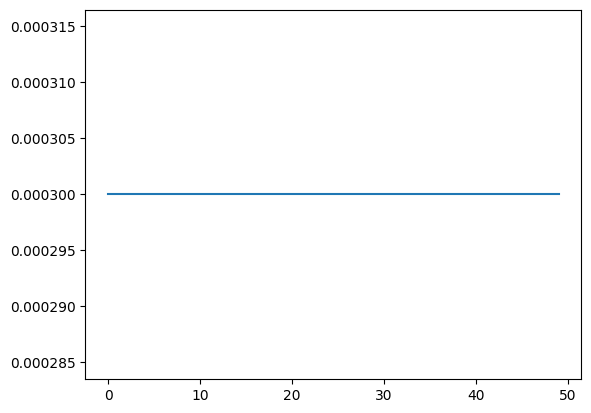

In [ ]:
trainer.plot_lr_schedule()

In [ ]:
trainer.train(model)

Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1. Train loss: 5.852887651884619, val loss: 5.147474847882, train score: 0.047732945091514115, val score: 0.04014900662251657


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2. Train loss: 4.655741512676248, val loss: 4.23562483598065, train score: 0.1257279534109816, val score: 0.12431015452538646


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3. Train loss: 3.617168480465295, val loss: 3.6541618906109528, train score: 0.2944051580698833, val score: 0.22475165562913912


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4. Train loss: 2.719798011311675, val loss: 2.823646344096455, train score: 0.4906405990016635, val score: 0.3858995584988961


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5. Train loss: 1.9108146543114048, val loss: 2.490586204244601, train score: 0.6774126455906861, val score: 0.46205849889624695


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 6. Train loss: 1.2583817715652768, val loss: 2.2093211980844982, train score: 0.8266430948419364, val score: 0.5213852097130243


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 7. Train loss: 0.7747796158772732, val loss: 2.1247315817321373, train score: 0.9285565723793743, val score: 0.5556015452538634


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 8. Train loss: 0.4717145734985739, val loss: 2.132907010664215, train score: 0.9760815307820337, val score: 0.5673289183222958


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 9. Train loss: 0.32224421877531767, val loss: 2.0693418423071597, train score: 0.9904326123128138, val score: 0.5880242825607064


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 10. Train loss: 0.2505086283393193, val loss: 2.213905387761578, train score: 0.9949043261231288, val score: 0.5802980132450329


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 11. Train loss: 0.2008896421814669, val loss: 2.325842940254717, train score: 0.9975041597337769, val score: 0.5793322295805741


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 12. Train loss: 0.19102931566406253, val loss: 2.5248103104038364, train score: 0.9975041597337769, val score: 0.5579470198675497


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 13. Train loss: 0.21596215083302542, val loss: 2.314347513562796, train score: 0.9964642262895176, val score: 0.5871964679911701


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 14. Train loss: 0.16146157318013357, val loss: 2.312122823386793, train score: 0.9969841930116472, val score: 0.5938189845474616


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 15. Train loss: 0.1779338560518831, val loss: 2.4767086553257824, train score: 0.9968801996672212, val score: 0.5710540838852097


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 16. Train loss: 0.16333740623977763, val loss: 2.35362471857213, train score: 0.9981281198003327, val score: 0.6121688741721857


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 17. Train loss: 0.13475958984279335, val loss: 2.6947415765152853, train score: 0.9966722129783696, val score: 0.5596026490066229


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 18. Train loss: 0.16738373513400143, val loss: 2.4696915727972177, train score: 0.9963602329450918, val score: 0.6025110375275939


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 19. Train loss: 0.1169098402534654, val loss: 2.549609543471938, train score: 0.9977121464226288, val score: 0.5991997792494483


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 20. Train loss: 0.12069631122461782, val loss: 2.569367113492347, train score: 0.9975041597337769, val score: 0.590921633554084


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 21. Train loss: 0.11256475819221709, val loss: 2.3822944951274536, train score: 0.997400166389351, val score: 0.6154801324503312


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 22. Train loss: 0.09918031655620027, val loss: 2.5267154903996083, train score: 0.9976081530782027, val score: 0.6080298013245035


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 23. Train loss: 0.10093058605870929, val loss: 2.635577208158984, train score: 0.9975041597337769, val score: 0.601269315673289


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 24. Train loss: 0.12417673520568946, val loss: 2.6033932937691553, train score: 0.9980241264559065, val score: 0.6041666666666669


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 25. Train loss: 0.11239239384541079, val loss: 2.6863107803271498, train score: 0.9966722129783692, val score: 0.6038907284768213


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 26. Train loss: 0.08819104876243725, val loss: 2.4983765861845972, train score: 0.997608153078203, val score: 0.6307947019867548


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 27. Train loss: 0.08588370931954258, val loss: 2.5674914697937625, train score: 0.997400166389351, val score: 0.6112030905077263


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 28. Train loss: 0.09343683419821973, val loss: 2.6106231183011017, train score: 0.9982321131447586, val score: 0.6134105960264902


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 29. Train loss: 0.11721652331807536, val loss: 2.722500053363921, train score: 0.9956322795341102, val score: 0.595060706401766


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 30. Train loss: 0.06567848044721301, val loss: 2.5487258085944, train score: 0.9980241264559065, val score: 0.6278973509933772


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 31. Train loss: 0.06378414991662623, val loss: 2.599030520347569, train score: 0.9976081530782027, val score: 0.6236203090507725


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 32. Train loss: 0.09284323628945063, val loss: 3.031245308798671, train score: 0.9969841930116472, val score: 0.5718818984547465


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 33. Train loss: 0.0895318711040343, val loss: 2.616739397165396, train score: 0.9977121464226286, val score: 0.6283112582781457


Training:   0%|          | 0/601 [00:00<?, ?it/s]

Validation:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 34. Train loss: 0.07377240191126713, val loss: 2.741780417397716, train score: 0.9975041597337767, val score: 0.6084437086092715


Training:   0%|          | 0/601 [00:00<?, ?it/s]

In [ ]:
torch.save(model, "/content/drive/MyDrive/Face Recognition/recognizer_v5.pt")

#Benchmarking

##Identification Rate

In [ ]:
!unzip "/content/drive/MyDrive/Face Recognition/celebA_ir.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: celebA_ir/celebA_distractors/137891.jpg  
  inflating: __MACOSX/celebA_ir/celebA_distractors/._137891.jpg  
  inflating: celebA_ir/celebA_distractors/012393.jpg  
  inflating: __MACOSX/celebA_ir/celebA_distractors/._012393.jpg  
  inflating: celebA_ir/celebA_distractors/116687.jpg  
  inflating: __MACOSX/celebA_ir/celebA_distractors/._116687.jpg  
  inflating: celebA_ir/celebA_distractors/139664.jpg  
  inflating: __MACOSX/celebA_ir/celebA_distractors/._139664.jpg  
  inflating: celebA_ir/celebA_distractors/029462.jpg  
  inflating: __MACOSX/celebA_ir/celebA_distractors/._029462.jpg  
  inflating: celebA_ir/celebA_distractors/132056.jpg  
  inflating: __MACOSX/celebA_ir/celebA_distractors/._132056.jpg  
  inflating: celebA_ir/celebA_distractors/092592.jpg  
  inflating: __MACOSX/celebA_ir/celebA_distractors/._092592.jpg  
  inflating: celebA_ir/celebA_distractors/026989.jpg  
  inflating: __MACOSX/celebA_i

In [ ]:
class IdRateMetric():
  def __init__(self, params):
    self.query_path = params["query_path"]
    self.distractors_path = params["distractors_path"]
    self.labels_path = params["labels_path"]
    self.device = params["device"]
    self.FPR = params["FPR"]
    self.set_size = params.get("set_size", 1)

    self.labels = self.get_labels_dict()
    self.equal_query_set = EqualQuerySet(self.query_path, self.labels, self.set_size)
    self.different_query_set = DifferentQuerySet(self.query_path, self.labels, self.set_size)
    self.query_distractors_set = QueryDistractorsSet(self.query_path, self.distractors_path, self.set_size)
  def __call__(self, model):
    model.eval()
    equal_query_loader = DataLoader(self.equal_query_set, batch_size=1024, shuffle=False)
    pos_pairs = self.compute_pairs_similarity(equal_query_loader, model, desc="Computing positive pairs")

    different_query_loader = DataLoader(self.different_query_set, batch_size=1024, shuffle=False)
    false_pairs_1 = self.compute_pairs_similarity(different_query_loader, model, desc="Computing false pairs from query")

    query_distractors_loader = DataLoader(self.query_distractors_set, batch_size=1024, shuffle=False)
    false_pairs_2 = self.compute_pairs_similarity(query_distractors_loader, model, desc="Computing false pairs from query and distractors")
    false_pairs = torch.cat([false_pairs_1, false_pairs_2])

    id_rate = self.compute_id_rate(pos_pairs, false_pairs)
    return id_rate

  def get_labels_dict(self):
    labels = pd.read_csv(self.labels_path)
    dictionary = {}
    for index, row in labels.iterrows():
      dictionary[row["img"]] = row["id"]
    return dictionary
  def compute_pairs_similarity(self, loader, model, desc=""):
    cos = nn.CosineSimilarity()
    pairs = None
    model = model.to(self.device)
    for batch in tqdm(loader, desc=desc):
      with torch.no_grad():
        first_items = batch[0].to(self.device)
        second_items = batch[1].to(self.device)
        first_embs = model.encoder(first_items)
        second_embs = model.encoder(second_items)
        coss = cos(first_embs, second_embs)
        sims = torch.abs(coss - torch.ones_like(coss))

        if pairs == None:
          pairs = sims.to("cpu")
        else:
          pairs = torch.cat([pairs, sims.to("cpu")])
    return pairs
  def compute_id_rate(self, pos_pairs, false_pairs):
    N = int(self.FPR*false_pairs.shape[0])
    false_sorted, indices = false_pairs.sort()
    trh = false_sorted[N].item()

    true_pos_count = (pos_pairs < trh).type("torch.LongTensor").sum().item()
    id_rate = true_pos_count/pos_pairs.shape[0]
    return id_rate

In [ ]:
class EqualQuerySet(Dataset):
  def __init__(self, path, labels, size=1):
    self.path = path
    self.size = size
    self.pairs = self.get_pairs(labels)
  def __len__(self):
    return len(self.pairs)
  def __getitem__(self, ind):
    pair = self.pairs[ind]
    image1 = cv2.imread(os.path.join(self.path, pair[0]))
    image1_tensor = torch.Tensor(image1).permute(2, 0, 1)
    image2 = cv2.imread(os.path.join(self.path, pair[1]))
    image2_tensor = torch.Tensor(image2).permute(2, 0, 1)
    return image1_tensor, image2_tensor
  def get_pairs(self, labels):
    groups = self.group_images(labels)
    pairs = []
    for label in groups.keys():
      images = groups[label]
      for i in range(len(images)):
        if i == len(images)-1:
          continue
        for j in range(i+1, len(images)):
          pair = [images[i], images[j]]
          pairs.append(pair)
    return pairs
  def group_images(self, labels):
    groups = {}
    all_images = os.listdir(self.path)
    random.shuffle(all_images)
    all_images = all_images[0:int(len(all_images)*self.size)]
    for image in labels.keys():
      if image not in all_images:
        continue
      if not image.endswith("jpg"):
        continue
      label = labels[image]
      if label not in groups:
        groups[label] = [image]
      else:
        groups[label].append(image)
    return groups

In [ ]:
class DifferentQuerySet(Dataset):
  def __init__(self, path, labels, size=1):
    self.path = path
    self.size = size
    self.pairs = self.get_pairs(labels)
  def __len__(self):
    return len(self.pairs)
  def __getitem__(self, ind):
    pair = self.pairs[ind]
    image1 = cv2.imread(os.path.join(self.path, pair[0]))
    image1_tensor = torch.Tensor(image1).permute(2, 0, 1)
    image2 = cv2.imread(os.path.join(self.path, pair[1]))
    image2_tensor = torch.Tensor(image2).permute(2, 0, 1)
    return image1_tensor, image2_tensor
  def get_pairs(self, labels):
    groups = self.group_images(labels)
    pairs = []
    for label in groups.keys():
      images = groups[label].copy()
      for image in images:
        for another_label in groups.keys():
          if label == another_label:
            continue
          another_images = groups[another_label].copy()
          for another_image in another_images:
            pair = [image, another_image]
            pairs.append(pair)
        groups[label].remove(image)
    return pairs

  def group_images(self, labels):
    groups = {}
    all_images = os.listdir(self.path)
    random.shuffle(all_images)
    all_images = all_images[0:int(len(all_images)*self.size)]
    for image in labels.keys():
      if image not in all_images:
        continue
      if not image.endswith("jpg"):
        continue
      label = labels[image]
      if label not in groups:
        groups[label] = [image]
      else:
        groups[label].append(image)
    return groups

In [ ]:
class QueryDistractorsSet(Dataset):
  def __init__(self, query_path, distractors_path, size=1):
    self.query_path = query_path
    self.distractors_path = distractors_path
    self.size = size
    self.pairs = self.get_pairs()
  def __len__(self):
    return len(self.pairs)
  def __getitem__(self, ind):
    pair = self.pairs[ind]
    image1 = cv2.imread(os.path.join(self.query_path, pair[0]))
    image1_tensor = torch.Tensor(image1).permute(2, 0, 1)
    image2 = cv2.imread(os.path.join(self.distractors_path, pair[1]))
    image2_tensor = torch.Tensor(image2).permute(2, 0, 1)
    return image1_tensor, image2_tensor
  def get_pairs(self):
    query = os.listdir(self.query_path)
    random.shuffle(query)
    query = query[0:int(len(query)*self.size)]
    distractors = os.listdir(self.distractors_path)
    random.shuffle(distractors)
    distractors = distractors[0:int(len(distractors)*self.size)]
    pairs = []
    for q in query:
      if not q.endswith("jpg"):
        continue
      for d in distractors:
        if not d.endswith("jpg"):
          continue
        pair = [q, d]
        pairs.append(pair)
    return pairs

In [ ]:
model = torch.load("/content/drive/MyDrive/Face Recognition/recognizer_v1.pt")

In [ ]:
params = {
    "query_path":"/content/celebA_ir/celebA_query",
    "distractors_path":"/content/celebA_ir/celebA_distractors",
    "labels_path":"/content/celebA_ir/celebA_anno_query.csv",
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "FPR":0.01,
    "set_size":0.1
}
metric = IdRateMetric(params)

In [ ]:
id_rate = metric(model)

Computing positive pairs:   0%|          | 0/1 [00:00<?, ?it/s]

Computing false pairs from query:   0%|          | 0/8 [00:00<?, ?it/s]

Computing false pairs from query and distractors:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
id_rate

0.043478260869565216

##Accuracy

In [ ]:
class AccuracyMetric():
  def __init__(self, params):
    self.test_dataset = params["test_dataset"]
    self.device = params.get("device", "cpu")
    self.score = AccuracyScore()
  def __call__(self, model):
    dataloader = DataLoader(self.test_dataset, batch_size=128, shuffle=False)
    model = model.to(self.device)
    model.eval()
    total_score = 0
    for batch in tqdm(dataloader):
      val_batch = batch["val"]
      for key in val_batch.keys():
        val_batch[key] = val_batch[key].to(self.device)
      labels = batch["labels"]
      for key in labels.keys():
        labels[key] = labels[key].to(self.device)
      with torch.no_grad():
        preds = model.predict(val_batch)
        score = self.score(preds, labels)
        total_score += score/(len(dataloader))
    return total_score

In [ ]:
test_dataset = FaceDataset("/content/celebA_train_500", train=False)
params = {
    "test_dataset":test_dataset,
    "device":"cuda" if torch.cuda.is_available() else "cpu"
}
accuracy = AccuracyMetric(params)
score = accuracy(model)

  0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
score

0.839931522171406